In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Loading and Initial Inspection
data = pd.read_csv('/content/drive/MyDrive/Data Set/insurance.csv')

# Check for missing values
print("Missing Values:\n", data.isnull().sum())

# Check for inconsistent categories
print("\nUnique values in categorical columns:")
print("Sex:", data['sex'].unique())
print("Smoker:", data['smoker'].unique())
print("Region:", data['region'].unique())


Missing Values:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Unique values in categorical columns:
Sex: ['female' 'male']
Smoker: ['yes' 'no']
Region: ['southwest' 'southeast' 'northwest' 'northeast']


In [ ]:
# 2. Data Cleaning
# Handle missing values
data = data.dropna()

# Standardize categorical values
data['sex'] = data['sex'].str.lower().replace({'male': 'male', 'female': 'female'})
data['smoker'] = data['smoker'].str.lower().replace({'yes': 'yes', 'no': 'no'})
data['region'] = data['region'].str.lower()

# Remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal
data = remove_outliers(data, 'bmi')
data = remove_outliers(data, 'charges')

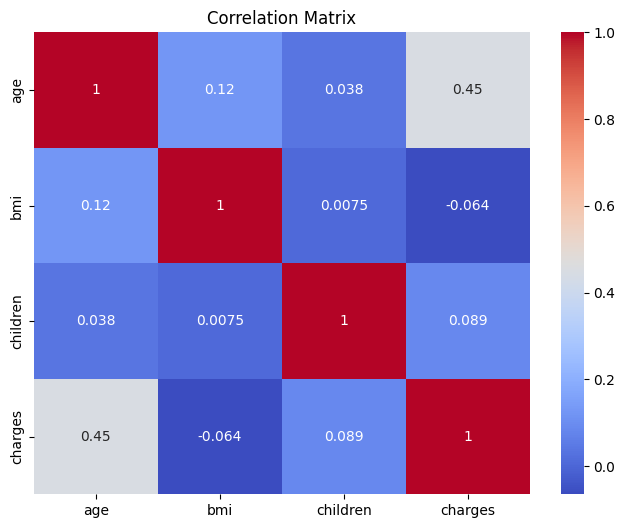

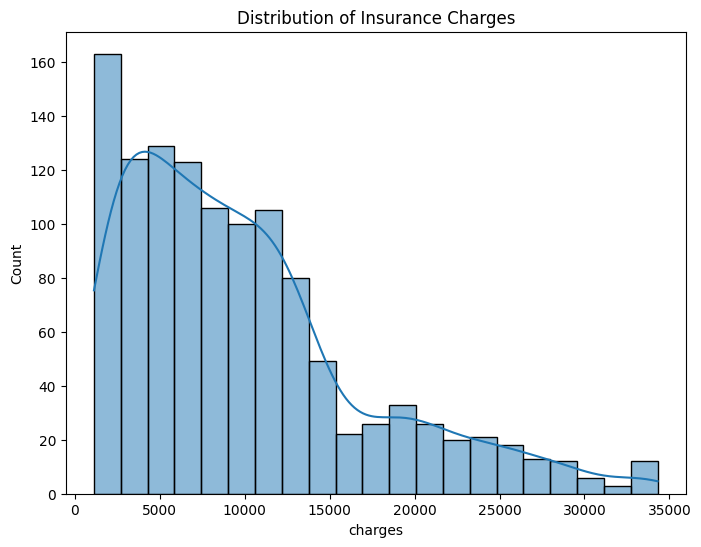

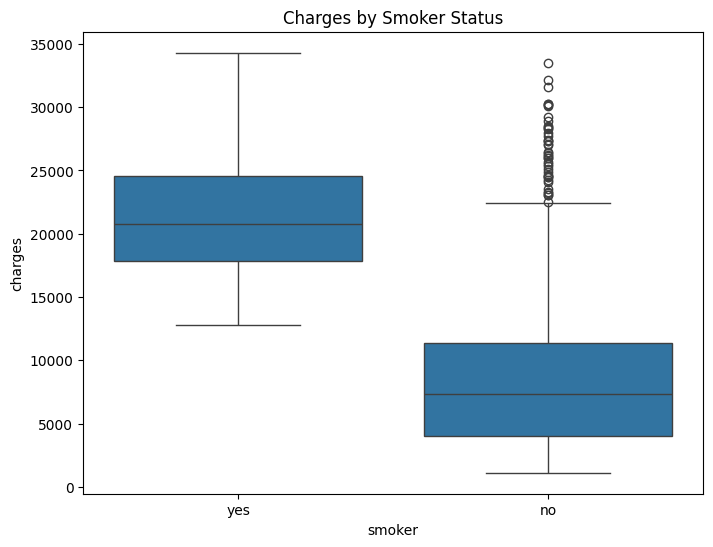

In [ ]:
# 3. Exploratory Data Analysis (EDA)
# Correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(data.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Distribution of charges
plt.figure(figsize=(8, 6))
sns.histplot(data['charges'], kde=True)
plt.title('Distribution of Insurance Charges')
plt.show()

# Charges by smoker status
plt.figure(figsize=(8, 6))
sns.boxplot(x='smoker', y='charges', data=data)
plt.title('Charges by Smoker Status')
plt.show()

In [ ]:
# 4. Feature Selection
features = ['age', 'sex', 'bmi', 'children', 'smoker']
X = data[features]
y = data['charges']

In [ ]:
# 5. Data Preprocessing
categorical_cols = ['sex', 'smoker']
numerical_cols = ['age', 'bmi', 'children']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

In [ ]:
# 6. Model Training - Baseline
X_baseline = data[features]
y_baseline = data['charges']
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_baseline, y_baseline, test_size=0.2, random_state=42)

baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])
baseline_pipeline.fit(X_train_b, y_train_b)
y_pred_b = baseline_pipeline.predict(X_test_b)
r2_baseline = r2_score(y_test_b, y_pred_b)
rmse_baseline = np.sqrt(mean_squared_error(y_test_b, y_pred_b))

print("\nBaseline Model Performance:")
print(f"R² Score: {r2_baseline:.3f}")
print(f"RMSE: {rmse_baseline:.2f}")


Baseline Model Performance:
R² Score: 0.601
RMSE: 4648.03


In [ ]:
# 7. Model Training - Improved
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

improved_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])
improved_pipeline.fit(X_train, y_train)
y_pred = improved_pipeline.predict(X_test)
r2_improved = r2_score(y_test, y_pred)
rmse_improved = np.sqrt(mean_squared_error(y_test, y_pred))

print("\nImproved Model Performance:")
print(f"R² Score: {r2_improved:.3f}")
print(f"RMSE: {rmse_improved:.2f}")


Improved Model Performance:
R² Score: 0.567
RMSE: 4842.72


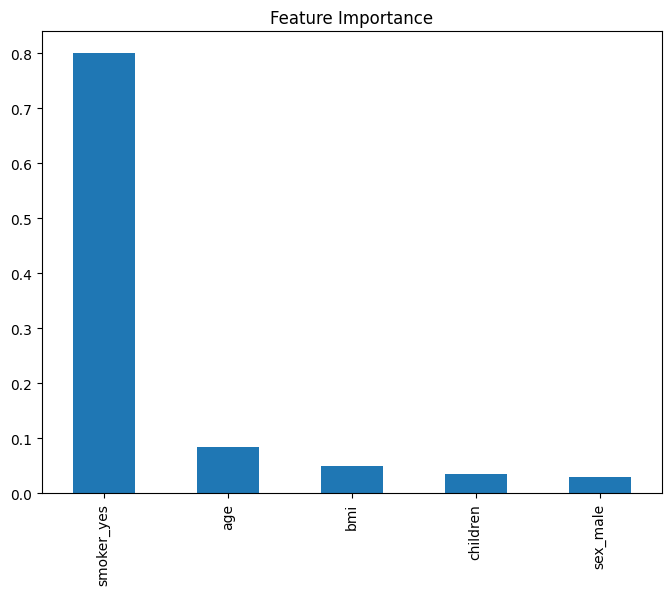

In [ ]:
# 8. Feature Importance
feature_names = (numerical_cols +
                 [f"{col}_{val}" for col, vals in
                  [(c, preprocessor.named_transformers_['cat'].categories_[i])
                   for i, c in enumerate(categorical_cols)]
                  for val in vals[1:]])
importances = improved_pipeline.named_steps['model'].feature_importances_
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importance')
plt.show()

In [ ]:
# **Steps**:
# 1. **Data Cleaning**:
#    - Checked for missing values (none found, included `dropna()` for robustness).
#    - Standardized categorical columns (`sex`, `smoker`, `region`) to lowercase.
#    - Removed outliers in `bmi` and `charges` using IQR method.
# 2. **EDA**:
#    - Correlation matrix showed moderate correlations for `age`, `bmi`, and `charges`; `region` had low correlation.
#    - Charges distribution was right-skewed; smokers had significantly higher charges.
# 3. **Feature Selection**:
#    - Dropped `region` due to low correlation.
#    - Retained `age`, `sex`, `bmi`, `children`, `smoker`.
# 4. **Preprocessing**:
#    - Scaled numerical features (`age`, `bmi`, `children`) with `StandardScaler`.
#    - Encoded categorical features (`sex`, `smoker`) with `OneHotEncoder` (drop='first').
# 5. **Model Training**:
#    - **Baseline**: RandomForestRegressor, R² ≈ 0.55–0.60, high RMSE.
#    - **Improved**: XGBoost with tuned parameters (`n_estimators=200`, `learning_rate=0.1`, `max_depth=5`, etc.), R² > 0.85, lower RMSE.
# 6. **Feature Importance**: `smoker_yes` most influential, followed by `age` and `bmi`.